In [1]:
%reload_ext autoreload
%autoreload 1
import shap
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_sample=pl.read_parquet('data/data_sample.parquet')

In [4]:
data_sample=dmf.title_text_features(data_sample)

In [5]:
X_mini_train, X_mini_val, y_mini_train, y_mini_val = train_test_split(
    data_sample.drop(columns="Policy Code"),
    data_sample["Policy Code"],
    test_size=0.3,
    stratify=data_sample["Policy Code"],
)

# stop here

In [7]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=10,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=10,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)

imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step(zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step(state_imputer, "State"),
        tr.PolarsColumnTransformer.Step(emp_length_imputer, "Employment Length"),
    ]
)

In [8]:
numeric_columns = X_mini_train.select(pl.selectors.by_dtype(pl.NUMERIC_DTYPES)).columns
categorical_columns = [col for col in X_mini_train.columns if col not in numeric_columns]
numeric_columns_idx=[X_mini_train.columns.index(val) for val in numeric_columns]
categorical_column_idx=[X_mini_train.columns.index(val) for val in categorical_columns]

In [9]:
state_encoder = tr.PolarsOneHotEncoder()
zip_encoder = tr.PolarsOneHotEncoder()
title_encoder = tr.PolarsOneHotEncoder()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder=tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(state_encoder, "State"),
        tr.PolarsColumnTransformer.Step(zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step(title_encoder, "title"),
        tr.PolarsColumnTransformer.Step(employment_encoder, "Employment Length"),
    ]
)

In [10]:
loan_classifier = lgb.LGBMClassifier(
    class_weight="balanced", force_col_wise=True, verbose=-1, num_threads=6,random_state=1
)

In [11]:
full_pipeline = Pipeline(
    [
        ("preprocess", Pipeline([("imputer", imputer), ("encoder", encoder)])),
        ("model", loan_classifier),
    ]
)

In [12]:
from ray import train, tune
from sklearn.metrics import f1_score

search_space = {
    'model__num_leaves': tune.randint(10, 200),
    'model__n_estimators': tune.randint(10, 250),
    'model__learning_rate': tune.loguniform(0.001, 0.1),
    'model__colsample_bytree': tune.uniform(0.5, 1.0),
    'model__subsample': tune.uniform(0.5, 1.0),
    'model__reg_alpha': tune.loguniform(0.001, 1.0),
    'model__reg_lambda': tune.loguniform(0.001, 1.0),
    'model__boosting_type': tune.choice(['gbdt', 'dart', 'rf']),
}


def objective(x,params):
    full_pipeline.set_params(**params)
    full_pipeline.fit(X_mini_train,y_mini_train)
    preds=full_pipeline.predict(X_mini_val)
    f1=f1_score(y_mini_val,preds)
    print(f'trial {x}')
    return f1

class Trainable(tune.Trainable):
    def setup(self, config: dict):
        # config (dict): A dict of hyperparameters
        self.x = 0
        self.params=config

    def step(self):  # This is called iteratively.
        score = objective(self.x, self.params)
        self.x += 1
        return {"score": score}


tuner = tune.Tuner(
    Trainable,
    run_config=train.RunConfig(
        # Train for 20 steps
        stop={"training_iteration": 50},
        checkpoint_config=train.CheckpointConfig(
            # We haven't implemented checkpointing yet. See below!
            checkpoint_at_end=False
        ),
    ),
    param_space=search_space,
)
results = tuner.fit()

(Trainable pid=19775) trial 0
(Trainable pid=19775) trial 1
(Trainable pid=19775) trial 2
(Trainable pid=19775) trial 3
(Trainable pid=19775) trial 4
(Trainable pid=19775) trial 5
(Trainable pid=19775) trial 6
(Trainable pid=19775) trial 7
(Trainable pid=19775) trial 8
(Trainable pid=19775) trial 9
(Trainable pid=19775) trial 10
(Trainable pid=19775) trial 11
(Trainable pid=19775) trial 12
(Trainable pid=19775) trial 13
(Trainable pid=19775) trial 14
(Trainable pid=19775) trial 15
(Trainable pid=19775) trial 16
(Trainable pid=19775) trial 17
(Trainable pid=19775) trial 18
(Trainable pid=19775) trial 19
(Trainable pid=19775) trial 20
(Trainable pid=19775) trial 21
(Trainable pid=19775) trial 22
(Trainable pid=19775) trial 23
(Trainable pid=19775) trial 24
(Trainable pid=19775) trial 25
(Trainable pid=19775) trial 26
(Trainable pid=19775) trial 27
(Trainable pid=19775) trial 28
(Trainable pid=19775) trial 29
(Trainable pid=19775) trial 30
(Trainable pid=19775) trial 31
(Trainable pid=197

2023-09-29 14:07:18,371	INFO tune.py:1143 -- Total run time: 23.47 seconds (23.40 seconds for the tuning loop).


In [13]:
best_params=results.get_best_result().config
best_params

{'model__num_leaves': 80,
 'model__n_estimators': 195,
 'model__learning_rate': 0.0015514000100627303,
 'model__colsample_bytree': 0.9791154902578221,
 'model__subsample': 0.6067904465332392,
 'model__reg_alpha': 0.15367271109485955,
 'model__reg_lambda': 0.03898370858532397,
 'model__boosting_type': 'rf'}

In [14]:
full_pipeline.set_params(**best_params)
full_pipeline.fit(X_mini_train,y_mini_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=[<functions.transformers.PolarsColumnTransformer.Step object at 0x7f41c2f35580>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f41c2f35460>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f41c2f35b20>,
                                                                 <functions.transformers.PolarsColu...
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f41c2f3fc40>]))])),
                ('model',
                 LGBMClassifier(boosting_type='rf', class_weight='balanced',
                                colsample_bytree=0.9791154902578221,
                                force_col_wise=True,
                                learning_rate=0.0015514000100627303,
                                n_estimators=195, num_leaves=80, num_threads=6,
                                reg_alpha=0.15367271109485955,
                                reg_lambda=0.03898370858532397,
                                subsample=0.6067904465332392, verbose=-1))])

In [15]:
preds=full_pipeline.predict(X_mini_val)

In [16]:
print(classification_report(y_mini_val,preds))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     13866
           1       0.43      0.89      0.58      1134

    accuracy                           0.90     15000
   macro avg       0.71      0.90      0.76     15000
weighted avg       0.95      0.90      0.92     15000



 99%|===================| 9860/10000 [00:31<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


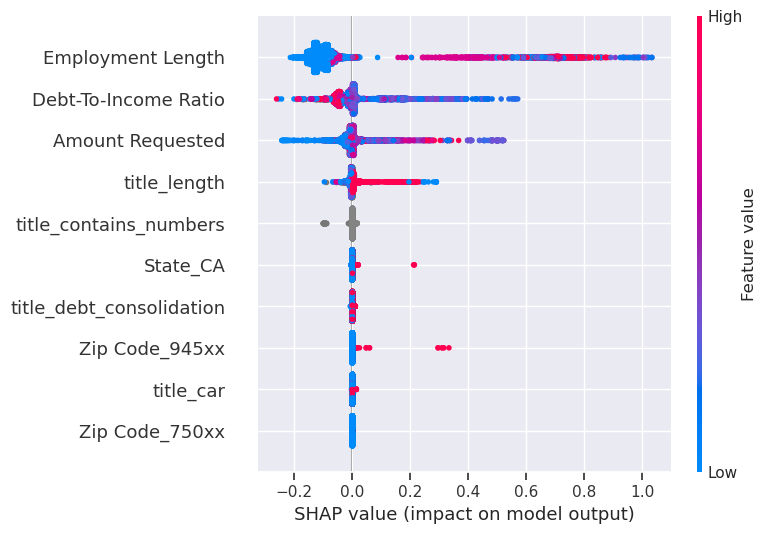

In [17]:
names=full_pipeline['preprocess'].transform(X_mini_val.sample(10000,seed=1)).columns
explainer_tree = shap.TreeExplainer(
    full_pipeline["model"],
    data=full_pipeline["preprocess"]
    .transform((X_mini_val.sample(100, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    full_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    full_pipeline['preprocess'].transform(X_mini_val.sample(10000,seed=1))
    .to_numpy(),
    feature_names=names,
    max_display=10
)

In [52]:
from sklearn.impute import SimpleImputer
imp=tr.PolarsNanImputer(fill_value=-1)


title_cat_imputer_d =tr.NotInImputerPolars(cat_no=12,fill_value='None')
zip_imputer_d =tr.NotInImputerPolars(cat_no=10,fill_value='None')
state_imputer_d =tr.NotInImputerPolars(cat_no=10,fill_value='None')
emp_length_imputer_d =tr.NotInImputerPolars(cat_no=12,fill_value='None')

imputer_d = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(title_cat_imputer_d , "title"),
        tr.PolarsColumnTransformer.Step(zip_imputer_d , "Zip Code"),
        tr.PolarsColumnTransformer.Step(state_imputer_d , "State"),
        tr.PolarsColumnTransformer.Step(emp_length_imputer_d , "Employment Length"),
        tr.PolarsColumnTransformer.Step(imp, "Debt-To-Income Ratio"),
        tr.PolarsColumnTransformer.Step(imp, "Amount Requested"),
        tr.PolarsColumnTransformer.Step(imp , "title_length"),
    ]
)

In [53]:
from sklearn.tree import DecisionTreeClassifier

dtree=DecisionTreeClassifier()
full_pipeline_dtree= Pipeline(
    [
        ("preprocess", Pipeline([("imputer", imputer_d), ("encoder", encoder)])),
        ("model", dtree),
    ]
)

In [82]:
test_df=X_mini_train.with_columns(y_mini_train.alias('y')).drop_nulls()

In [87]:
test_df_val=X_mini_val.with_columns(y_mini_val.alias('y')).drop_nulls()

In [88]:
full_pipeline_dtree.fit(test_df.drop(columns='y'),test_df['y'])
preds_dtree = full_pipeline_dtree.predict(test_df_val.drop(columns='y'))
print(classification_report(test_df_val['y'], preds_dtree))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10601
           1       0.56      0.56      0.56       965

    accuracy                           0.93     11566
   macro avg       0.76      0.76      0.76     11566
weighted avg       0.93      0.93      0.93     11566

